In [139]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
import astropy
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
import numpy as np
#import ogr
#import shapely.wkt
#import shapely.geometry
import urllib.request
import zipfile
import json
import csv
from collections import Counter
import itertools
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os, glob
from sklearn import decomposition
from sklearn import cluster
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from scipy import spatial
from io import StringIO
import importlib
from mpl_toolkits.mplot3d import Axes3D
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import PIL
from PIL import Image
import scipy.misc
import math
from scipy.spatial.distance import pdist, squareform
import cv2

In [181]:
def data_normalization(data): #normalizes data to a gaussian
    new_data = preprocessing.normalize(np.log(data))
    return new_data

def Get_Round_Pixel_Locations(data,radius,center_x,center_y): 
    #gets the coordinates of pixels in the round arrea. Outputs a n*2 array
    len_y = np.shape(data)[0]
    len_x = np.shape(data)[1]
    out = [[None,None]] #stores the coordinate of the pixels
    for j in range(0,len_y-1):
        for i in range(0,len_x-1):
            if ((i-center_x)**2 + (j-center_y)**2) < radius**2:
                out.append([i,j])
    out = np.delete(out, 0, 0)  # delete first row of out
    return out #Returns the Loc: location of the pixels

def Get_Ring_Pixel_Locations(data,radius_inner,radius_outer,center_x,center_y): 
    #gets the coordinates of pixels in the round arrea. Outputs a n*2 array
    len_y = np.shape(data)[0]
    len_x = np.shape(data)[1]
    out = [[None,None]] #stores the coordinate of the pixels
    for j in range(0,len_y-1):
        for i in range(0,len_x-1):
            if ((((i-center_x)**2 + (j-center_y)**2) <= radius_outer**2) & (((i-center_x)**2 + (j-center_y)**2) >= radius_inner**2) ):
                out.append([i,j])
    out = np.delete(out, 0, 0)  # delete first row of out
    return out #Returns the Loc: location of the pixels

def Get_Data(data, Loc): 
    #returns the converted pixels using the coordinates
    n = np.shape(Loc)[0]
    out = np.zeros([np.shape(Loc)[0],1])
    for i in range(0,n-1):
        out[i] = data[Loc[i,0],Loc[i,1]]
    return out

def Reconstruct_Data(data_Vec,Loc,x_len,y_len):
    n = np.shape(Loc)[0]
    out = np.zeros([x_len,y_len])
    for i in range(0,n-1):
        out[Loc[i,0],Loc[i,1]] = data_Vec[i]
    return out

def read_txt(txt,filename): #reads the txt file, converts the txt file to list
    a = []
    with open(txt, 'r') as f:
        while True:
            line = f.readline() 
            b = line.split()
            a.append(b)
            if not line:
                return a
                break     
                
def convert_label(label): #tokenize the labels
    if label == 'n':  
        out = 0
    elif label == 'm':
        out = 1
    elif label == 'o':
        out = 2
    elif label == 'p':
        out = 3
    elif label == 'i':
        out = 4
    elif label == 'u':
        out = 5
    else:
        out = 6
    return out

# def get_hourly_mean(rootDir,hour,Loc_C,Loc_R): #calculates the mean data hourly, outputs the blue and red band data
#     list_dirs = os.walk(rootDir)
#     a = ''
#     cnt1 = 0
#     cnt2 = 0
#     data1C_sum = np.zeros([np.shape(Loc_C)[0]])
#     data2C_sum = np.zeros([np.shape(Loc_C)[0]])
#     data1R_sum = np.zeros([np.shape(Loc_R)[0]])
#     data2R_sum = np.zeros([np.shape(Loc_R)[0]])
#     for root, dirs, files in list_dirs: 
#         for d in files: 
#             path = os.path.join(root, d)
#             str0 = path.split('\\')[-1]
#             str1 = str0[3]
#             str2 = str0[14]+str0[15]
            
#             if str1 == "b":
#                 if str2 == hour:
#                     cnt1 += 1
#                     image_file = path
#                     fits.info(image_file)
#                     image_data = fits.getdata(image_file, ext=0)
#                     image_data = data_normalization(np.log(image_data))
#                     data_C1 = Get_Data(image_data,Loc_C)
#                     #data_R1 = Get_Data(image_data,Loc_R)
#                     data1C_sum = data1C_sum + data_C1
#                     #data1R_sum = data1R_sum + data_R1
                    
#             elif str1 == "r":
#                 if str2 == hour:
#                     cnt2 += 1
#                     image_file = path
#                     #fits.info(image_file)
#                     image_data = fits.getdata(image_file, ext=0)
#                     image_data = data_normalization(np.log(image_data))
#                     #data_C2 = Get_Data(image_data,Loc_C)
#                     #data_R2 = Get_Data(image_data,Loc_R)
#                     #data2C_sum = data2C_sum + data_C2
#                     #data2R_sum = data2R_sum + data_R2
#             #print(str)
#     data1C_sum = data1C_sum/cnt1
#     data1R_sum = data1R_sum/cnt1
#     data2C_sum = data2C_sum/cnt2
#     data2R_sum = data2R_sum/cnt2
#     return data1C_sum, data1R_sum, data2C_sum,data2R_sum
def get_hourly_mean(rootDir,hour): #calculates the mean data hourly, outputs the blue and red band data
    list_dirs = os.walk(rootDir)
    a = ''
    cnt1 = 0
    cnt2 = 0
    data1 = np.zeros([256,256])
    data2 = np.zeros([256,256])
    for root, dirs, files in list_dirs: 
        for d in files: 
            path = os.path.join(root, d)
            str0 = path.split('\\')[-1]
            str1 = str0[3]
            str2 = str0[14]+str0[15]
            
            if str1 == "b":
                if str2 == hour:
                    cnt1 += 1
                    image_file = path
                    #fits.info(image_file)
                    
                    image_data = fits.getdata(image_file, ext=0)
                    
                    #image_data = data_normalization(np.log(image_data))
                    if image_data.shape[0] != 1024:
                        cnt1 -=1
                        continue
                    else:
                        image_data = cv2.resize(image_data,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
                        data1 = data1 + image_data
                    
                    #print(np.max(data1))
                    
            elif str1 == "r":
                if str2 == hour:
                    cnt2 += 1
                    image_file = path
                    #fits.info(image_file)
                    
                    image_data = fits.getdata(image_file, ext=0)
                    
                    #image_data = data_normalization(np.log(image_data))
                    if image_data.shape[0] != 1024:
                        cnt2 -= 1
                        continue
                    else:
                        image_data = cv2.resize(image_data,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_CUBIC)
                        data2 = data2 + image_data
                        
            #print(str)
    if cnt1 * cnt2 == 0:
        data1 = np.zeros([256,256])
        data2 = np.zeros([256,256])
        return data1,data2
    print(cnt1,cnt2)
    data1 = data1/cnt1
    data2 = data2/cnt2
    print(data1)
    data1 = data_normalization(data1)
    data2 = data_normalization(data2)
    return data1, data2    

def data_organizer(txtlist,Loc_C,Loc_R): #reshapes the data and restructure all data in the list. data: d*n label: n*1
    num_data = len(txtlist)
    #print(num_data)
    data_bC = np.zeros([np.shape(Loc_C)[0],num_data])
    #print(np.shape(data_bC))
#     data_bR = np.zeros([np.shape(Loc_R)[0],num_data])
#     data_rC = np.zeros([np.shape(Loc_C)[0],num_data])
#     data_rR = np.zeros([np.shape(Loc_R)[0],num_data])
    label_out = np.zeros(num_data)
    for i in range (num_data):
        str0 =  ''.join(txtlist[i][0:3])
        dir0 = image_folder + "\\" + str0
        hour =  ''.join(txtlist[i][3])
        label = ''.join(txtlist[i][4])
        label = convert_label(label)
        label_out[i] = label
        data1C_sum, data1R_sum, data2C_sum,data2R_sum = get_hourly_mean(dir0,hour,Loc_C,Loc_R)
        data_bC[:,i] = data1C_sum
    return data_bC,label_out
#         data_bR[:,i] = data1R_sum
#         data_rC[:,i] = data2C_sum
#         data_rR[:,i] = data2R_sum
#     return data_bC,data_bR,data_rC,data_rR,label_out
#def get_next_data(txtlist,Loc_C,Loc_R,i):
    
    

# Test on one image 

In [162]:
#generate a toy data
#image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
image_file = r'C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz'
#image_file = r'E:\T1-Tolar.20061126.asca\net\data\ASCA\20061126\to_b20061127ut000753s16260.fits.gz'
print(image_file)
fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
plt.figure()
#plt.imshow(data_normalization(np.log(image_data)), cmap='gray')
#plt.colorbar()
image_data = data_normalization(np.log(image_data))
r_out = 470
r_in = 470/np.sqrt(2)
x = 55+470
y = 35+470
#get locations
Loc_C = Get_Round_Pixel_Locations(image_data,r_in,x,y)
Loc_R = Get_Ring_Pixel_Locations(image_data,r_in,r_out,x,y)
#get data
#data_C = Get_Data(image_data,Loc_C)
#data_R = Get_Data(image_data,Loc_R)

print(np.shape(Loc_C)[0])
print(np.shape(Loc_R)[0])

C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz
Filename: C:\USB backup\Sem1, 2019\ENGN8602\sample_data\to_b20061127ut005945s19380.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
346985
346928


# Implement Incremental PCA

In [177]:
def data_organizer1(txtlist): #reshapes the data and restructure all data in the list. data: d*n label: n*1
    num_data = len(txtlist)
 #   print(num_data)
    data_bC = np.zeros([num_data,256*256])
    data_rC = np.zeros([num_data,256*256])
#     print(np.shape(data_bC))
#     data_bR = np.zeros([np.shape(Loc_R)[0],num_data])
#     data_rC = np.zeros([np.shape(Loc_C)[0],num_data])
#     data_rR = np.zeros([np.shape(Loc_R)[0],num_data])
    label_out = np.zeros(num_data)
    for i in range (num_data):
        print(i)
        str0 =  ''.join(txtlist[i][0:3])
        dir0 = image_folder + "\\" + str0
        hour =  ''.join(txtlist[i][3])
        label = ''.join(txtlist[i][4])
        label = convert_label(label)
        label_out[i] = label
        data1,data2 = get_hourly_mean(dir0,hour)
        data_bC[i,:] = data1.reshape((1,256*256))
        data_rC[i,:] = data2.reshape((1,256*256))
    return data_bC,data_rC,label_out
#         data_bR[:,i] = data1R_sum
#         data_rC[:,i] = data2C_sum
#         data_rR[:,i] = data2R_sum
#     return data_bC,data_bR,data_rC,data_rR,label_out
#def get_next_data(txtlist,Loc_C,Loc_R,i)

In [180]:
image_folder = 'E:\\TMT_DATA_2\\T2-Armazones'
txt = r'E:\\TMT_DATA_2\\T2-Armazones\\newlist.txt'
#def get_data_array(root_dir,txt):
b = read_txt(txt,image_folder)
b.remove(b[0])
b.remove(b[-1])
txtlist = b
str0 =  ''.join(b[0][0:3])
dir0 = image_folder + "\\" + str0
print(dir0)
hour =  ''.join(b[0][3])
n = len(txtlist)
data1,data2,label = data_organizer1(txtlist)

E:\TMT_DATA_2\T2-Armazones\20060601
0
15 15
[[127.53333333 130.4        125.4        ... 106.06666667 114.86666667
  121.66666667]
 [127.         131.46666667 132.33333333 ... 110.13333333  99.13333333
  112.13333333]
 [121.6        120.4        128.33333333 ... 106.4        109.53333333
  117.33333333]
 ...
 [129.66666667 147.73333333 126.93333333 ... 110.6        109.2
  114.13333333]
 [126.         142.46666667 128.26666667 ... 115.53333333 114.4
  117.4       ]
 [127.33333333 141.33333333 127.6        ... 113.4        126.93333333
  133.2       ]]
1
13 12
[[129.53846154 134.23076923 125.38461538 ... 105.38461538 115.69230769
  124.        ]
 [126.46153846 135.92307692 131.92307692 ... 111.          99.38461538
  115.38461538]
 [122.38461538 122.46153846 134.38461538 ... 105.84615385 109.69230769
  120.23076923]
 ...
 [132.38461538 153.38461538 127.15384615 ... 113.07692308 112.53846154
  117.46153846]
 [130.07692308 148.30769231 132.15384615 ... 117.30769231 113.53846154
  118.6153

c:\users\tony\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [165]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
newData=pca.fit_transform(data1)
print(data1)

[[0.06381494 0.06410752 0.0635929  ... 0.06163355 0.06310231 0.06373012]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [182]:
image_folder = 'E:\\TMT_DATA_2\\T2-Armazones'
txt = r'E:\\TMT_DATA_2\\T2-Armazones\\newlist.txt'
#def get_data_array(root_dir,txt):
b = read_txt(txt,image_folder)
b.remove(b[0])
b.remove(b[-1])
txtlist = b
str0 =  ''.join(b[0][0:3])
dir0 = image_folder + "\\" + str0
print(dir0)
hour =  ''.join(b[0][3])
n = len(txtlist)
batch_n = 50
iter_n = n//batch_n + 1
transformer = IncrementalPCA(n_components=7, batch_size=batch_n)
C1_transformed = np.zeros(1)
C1_transformed = C1_transformed.tolist()
C2_transformed = np.zeros(1)
C2_transformed = C2_transformed.tolist()
R1_transformed = np.zeros(1)
R1_transformed = R1_transformed.tolist()
R2_transformed = np.zeros(1)
R2_transformed = R2_transformed.tolist()
label_out = np.zeros(n)
data1C_new = np.zeros([batch_n,np.shape(Loc_C)[0]])
data2C_new = np.zeros([batch_n,np.shape(Loc_C)[0]])
data1R_new = np.zeros([batch_n,np.shape(Loc_R)[0]])
data2R_new = np.zeros([batch_n,np.shape(Loc_R)[0]])
total = 0
for i in range (iter_n):
    print("training on ",i+1," of ",iter_n," batches")
    data1C_new = data1C_new - data1C_new
    data2C_new = data2C_new - data2C_new
    data1R_new = data1R_new - data1R_new
    data2R_new = data2R_new - data2R_new
    for j in range(batch_n):
        str0 =  ''.join(txtlist[i*batch_n+j][0:3])
        dir0 = image_folder + "\\" + str0
        hour =  ''.join(txtlist[i*batch_n+j][3])
        label = ''.join(txtlist[i*batch_n+j][4])
        label = convert_label(label)
        data1_sum, data2_sum = get_hourly_mean(dir0,hour)
        if np.sum(data1_sum) == 0:
            continue
        else:
            label_out[i*batch_n+j] = label
            data1C_new[j,:] = Get_Data(data1_sum,Loc_C).T
            total = total + 1
            data2C_new[j,:] = Get_Data(data2_sum,Loc_C).T
            data1R_new[j,:] = Get_Data(data1_sum,Loc_R).T
            data2R_new[j,:] = Get_Data(data2_sum,Loc_R).T
    
    C1_transformed.extend(transformer.fit_transform(data1C_new))
    R1_transformed.extend(transformer.fit_transform(data1R_new))
    C2_transformed.extend(transformer.fit_transform(data2C_new))
    R2_transformed.extend(transformer.fit_transform(data2R_new))
    
    
C1_transformed = C1_transformed[1:]
R1_transformed = R1_transformed[1:]
R1_transformed = R1_transformed[1:]
R2_transformed = R2_transformed[1:]

    

E:\TMT_DATA_2\T2-Armazones\20060601
training on  1  of  14  batches
15 15
[[127.53333333 130.4        125.4        ... 106.06666667 114.86666667
  121.66666667]
 [127.         131.46666667 132.33333333 ... 110.13333333  99.13333333
  112.13333333]
 [121.6        120.4        128.33333333 ... 106.4        109.53333333
  117.33333333]
 ...
 [129.66666667 147.73333333 126.93333333 ... 110.6        109.2
  114.13333333]
 [126.         142.46666667 128.26666667 ... 115.53333333 114.4
  117.4       ]
 [127.33333333 141.33333333 127.6        ... 113.4        126.93333333
  133.2       ]]


IndexError: index 510 is out of bounds for axis 0 with size 256

In [22]:
#generate a toy data
#image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
image_file = r'E:\TMT_DATA_2\T2-Armazones\20051025\ar_r20051026ut085909s40710.fits.gz'
#image_file = r'E:\T1-Tolar.20061126.asca\net\data\ASCA\20061126\to_b20061127ut000753s16260.fits.gz'
print(image_file)
fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
plt.figure()
#plt.imshow(data_normalization(np.log(image_data)), cmap='gray')
#plt.colorbar()
image_data = data_normalization(np.log(image_data))
r_out = 470
r_in = 470/np.sqrt(2)
x = 55+470
y = 35+470
#get locations
Loc_C = Get_Round_Pixel_Locations(image_data,r_in,x,y)
Loc_R = Get_Ring_Pixel_Locations(image_data,r_in,r_out,x,y)
#get data
#data_C = Get_Data(image_data,Loc_C)
#data_R = Get_Data(image_data,Loc_R)

print(np.shape(Loc_C)[0])
print(np.shape(Loc_R)[0])

E:\TMT_DATA_2\T2-Armazones\20051025\ar_r20051026ut085909s40710.fits.gz
Filename: E:\TMT_DATA_2\T2-Armazones\20051025\ar_r20051026ut085909s40710.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (1024, 1024)   int16 (rescales to uint16)   
346985
346928


In [96]:

image_folder = 'E:\TMT_DATA_2\T2-Armazones'
txt = r'E:\TMT_DATA_2\T2-Armazones\usability_T2-Armazones_200510_200802_COMBINED .txt'
#def get_data_array(root_dir,txt):
b = read_txt(txt,image_folder)
b.remove(b[0])
b.remove(b[-1])
str0 =  ''.join(b[0][0:3])
dir0 = image_folder + "\\" + str0
dir0 = "E:\\TMT_DATA_2\\T2-Armazones\\20060620"
print(dir0)
hour =  ''.join(b[0][3])
print(hour)
#data1C_sum, data1R_sum, data2C_sum,data2R_sum = get_hourly_mean(dir0,hour,Loc_C,Loc_R)
data1_sum, data2_sum = get_hourly_mean(dir0,"09")
# data1C_sum = np.zeros([np.shape(Loc_C)[0]])
# data2C_sum = np.zeros([np.shape(Loc_C)[0]])
# data1R_sum = np.zeros([np.shape(Loc_R)[0]])
# data2R_sum = np.zeros([np.shape(Loc_R)[0]])
data1C_sum = Get_Data(data1_sum,Loc_C)
data2C_sum = Get_Data(data2_sum,Loc_C)
data1R_sum = Get_Data(data1_sum,Loc_R)
data2R_sum = Get_Data(data2_sum,Loc_R)
print(data1C_sum.T.shape)
print(np.sum(data1C_sum)==0)

E:\TMT_DATA_2\T2-Armazones\20060620
00
(1, 346985)
False


In [138]:
C1_transformed = C1_transformed[1:131]
R1_transformed = R1_transformed[1:131]
C2_transformed = C2_transformed[1:131]
R2_transformed = R2_transformed[1:131]

In [ ]:
''''
''class a and b
m: moon is up
''class b
p: no cloud
''class a
o: clouds only in the outer circle

i: clouds only in the inner circle

u:  full cover

''
n: undetermined/questionable data

130
(130,)
(130, 7)
(130, 3)
[[ 5.64825831e-02 -7.73240507e-02  0.00000000e+00]
 [ 2.72835973e-02 -6.51471529e-02  1.00000000e+00]
 [-1.20163976e-01 -1.95459889e-01  1.00000000e+00]
 [-1.38936013e-01 -2.33511718e-01  1.00000000e+00]
 [-2.25039950e-01 -2.43745685e-01  1.00000000e+00]
 [-6.27284483e-01 -5.61372044e-02  1.00000000e+00]
 [-3.62996771e-01  1.04866231e+00  1.00000000e+00]
 [ 9.66319273e-01  5.18195869e-01  1.00000000e+00]
 [ 7.55280951e-01 -3.42382202e-01  1.00000000e+00]
 [ 2.46782575e-01 -2.73158454e-01  1.00000000e+00]
 [ 6.39250673e-02 -1.12811033e-01  3.00000000e+00]
 [ 4.90785332e-02 -7.63689775e-02  3.00000000e+00]
 [ 3.22433070e-02 -6.40131594e-02  3.00000000e+00]
 [ 1.78734879e-02 -4.69667685e-02  1.00000000e+00]
 [-1.11472102e-01 -1.84029893e-01  1.00000000e+00]
 [-1.10197772e-01 -2.10183449e-01  1.00000000e+00]
 [-1.72279836e-01 -2.16495488e-01  1.00000000e+00]
 [-5.30813246e-01 -8.95328579e-04  1.00000000e+00]
 [-1.83879537e-01  9.73702782e-01  1.00000000e+00]
 [

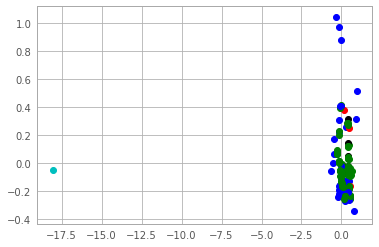

In [137]:
import matplotlib.pyplot as plt
print(len(C1_transformed))
a = label_out[:130]
print(a.shape)
b = np.asarray(C1_transformed)
print(b.shape)
b = b[:,:3]
b[:,2] = a.T
print(b.shape)
plt.figure

print(b)
for i in range(130):
    
    if b[i,2] == 1:
        plt.scatter(b[i,0], b[i,1],c='b')
    elif b[i,2] == 2:
        plt.scatter(b[i,0], b[i,1],c='r')
    elif b[i,2] == 3:
        plt.scatter(b[i,0], b[i,1],c='g')
    elif b[i,2] == 4:
        plt.scatter(b[i,0], b[i,1],c='k')
    else:
        plt.scatter(b[i,0], b[i,1],c='c')
plt.show()